In [645]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import pprint

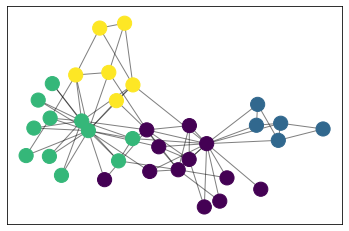

In [646]:
G=nx.Graph()
gr=pd.read_csv('karate.csv')
# gr=pd.read_csv('dolphin.csv')
#gr=pd.read_csv('football.csv')
edge=[(gr['Source'][i],gr['Destination'][i]) for i in range(0,len(gr['Source']))]
G.add_edges_from(edge)
node=max([max(x[0],x[1]) for x in edge])
# compute the best partition
# partition contains color of each node
partition = community_louvain.best_partition(G)

# visualization of clusters
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=200,cmap=cmap, node_color=list(partition.values()),)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [647]:
# Generating gateEdges
# gateEdges contains edges--> [(a,b),(b,c)]
gateEdges=[]
for x in edge:
    if(partition[x[0]]!=partition[x[1]]):
        gateEdges.append(x)

# Generating gate nodes 
gateNodesDict={}

for tup in gateEdges:
    gateNodesDict[tup[0]]=1
    gateNodesDict[tup[1]]=1

gateNodesList=list(gateNodesDict.keys())

print("Gateway graph nodes:",gateNodesList)
for x in gateNodesList:
    for y in gateNodesList:
        if(x==y or ((x,y) in gateEdges) or ((y,x) in gateEdges)):
            continue
        else:
            if(partition[x]==partition[y]):
                if((x,y) in edge or (y,x) in edge):
                    gateEdges.append((x,y))
gatewayGraph=nx.Graph()
gatewayGraph.add_edges_from(gateEdges)

Gateway graph nodes: [5, 1, 6, 7, 9, 3, 11, 28, 29, 30, 24, 31, 2, 32, 33, 34, 10, 14, 20]


In [648]:
# Gate graph
# This is the gate way graph
# gate
tot_g=[]
tot_graphs=[]
for i in range(0,500):
    g = G
    gatew = gatewayGraph
    attr = {(u, v): {"weight": round(random.uniform(0,1),2)} for (u, v) in G.edges()}
    nx.set_edge_attributes(g, attr)
    tot_g.append(g.subgraph(gatew))
    tot_graphs.append(g)

# for k in range(0,500):
#     print(len(tot_g[k]))
#     tot_g[k].add_nodes_from(gateNodesList)
#     print(len(tot_g[k]))
#     for i in range(0,len(gateEdges)):
#         tot_g[k].add_edge(gateEdges[i][0],gateEdges[i][1],weight=round(random.uniform(0,1),2))
#     break

In [649]:
#BCS Score
def BCS(gg,nodes,nodeList):
    BCS_={}
    for node in nodeList:
        BCS_[node]=0
    for i in gg:
        x=(nx.betweenness_centrality(i,weight='weight'))
        for j in x:
            BCS_[j]+=(1/500)*x[j]
    return BCS_
BCS_value=BCS(tot_g,len(gateNodesList),gateNodesList)
BCS_value=(sorted(BCS_value.items(), key=lambda x: x[1],reverse=True))
print(BCS_value)

[(1, 0.47058823529411337), (3, 0.2287581699346422), (34, 0.2156862745098064), (33, 0.19607843137255024), (32, 0.15686274509803805), (14, 0.11111111111111056), (29, 0.019607843137254756), (9, 0.013071895424836623), (10, 0.013071895424836623), (5, 0.0), (6, 0.0), (7, 0.0), (11, 0.0), (28, 0.0), (30, 0.0), (24, 0.0), (31, 0.0), (2, 0.0), (20, 0.0)]


In [650]:
# Model selection - diffusion time
model = ep.SIModel(G)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion={}
for i in range(1,node+1):
    time_of_diffusion[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion[j]=i['iteration']

100%|██████████| 200/200 [00:00<00:00, 2150.57it/s]


In [651]:
print(time_of_diffusion)

{1: 35, 2: 38, 3: 38, 4: 46, 5: 48, 6: 51, 7: 39, 8: 44, 9: 22, 10: 27, 11: 68, 12: 39, 13: 40, 14: 49, 15: 16, 16: 20, 17: 74, 18: 39, 19: 20, 20: 19, 21: 16, 22: 38, 23: 22, 24: 13, 25: 35, 26: 10, 27: 22, 28: 16, 29: 22, 30: 19, 31: 49, 32: 0, 33: 11, 34: 14}


In [652]:
sensor_nodes=[BCS_value[i][0] for i in range(0,3)]
print(sensor_nodes)
print(gateNodesList)
print(len(gateEdges))

[1, 3, 34]
[5, 1, 6, 7, 9, 3, 11, 28, 29, 30, 24, 31, 2, 32, 33, 34, 10, 14, 20]
44


In [653]:
delta_t=[]
min_v=min([time_of_diffusion[i] for i in sensor_nodes])
min_n=-1
for i in sensor_nodes:
    if(time_of_diffusion[i]==min_v):
        min_n=i
        break
delta_t=[abs(time_of_diffusion[i]-min_v) for i in sensor_nodes if(i!=min_n)]
print(delta_t)

[21, 24]


In [654]:
timeOfDiffusions=[]
for i in tot_g:
    print(len(i.edges()))
    # Model selection - diffusion time
    model = ep.SIModel(i)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', 0.03)
    cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
    model.set_initial_status(cfg)

    # Simulation execution
    iterations = model.iteration_bunch(200)

    #Mapping diffusion_time_to_each_node
    time_of_diffusion={}
    for i in range(1,node+1):
        time_of_diffusion[i]=-1
    for i in iterations:
        for j in i['status']:
            if(i['status'][j]==1):
                time_of_diffusion[j]=i['iteration']
    timeOfDiffusions.append(len(time_of_diffusion))

44

 38%|███▊      | 75/200 [00:00<00:00, 742.63it/s]

 40%|████      | 81/200 [00:00<00:00, 802.01it/s]

44


 38%|███▊      | 75/200 [00:00<00:00, 749.94it/s]

44


 38%|███▊      | 77/200 [00:00<00:00, 769.99it/s]

44


 43%|████▎     | 86/200 [00:00<00:00, 851.49it/s]

44


 38%|███▊      | 77/200 [00:00<00:00, 769.99it/s]

44


 40%|████      | 80/200 [00:00<00:00, 792.09it/s]

44


 36%|███▋      | 73/200 [00:00<00:00, 722.75it/s]

44


 40%|████      | 81/200 [00:00<00:00, 809.99it/s]

44


 41%|████      | 82/200 [00:00<00:00, 819.91it/s]

44


 48%|████▊     | 97/200 [00:00<00:00, 960.46it/s]

44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2127.93it/s]

44
44



 95%|█████████▌| 190/200 [00:00<00:00, 1881.36it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2353.07it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2272.78it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2082.95it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2381.33it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2221.67it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2272.74it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


 85%|████████▌ | 170/200 [00:00<00:00, 1699.92it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2221.84it/s]

44
44



100%|██████████| 200/200 [00:00<00:00, 2469.47it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2531.67it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2298.95it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 1980.25it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2247.02it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2409.40it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2273.02it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2298.47it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2410.03it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2531.72it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2353.46it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2352.85it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


 50%|████▉     | 99/200 [00:00<00:00, 989.99it/s]

44


 52%|█████▎    | 105/200 [00:00<00:00, 1039.64it/s]

44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2273.03it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2299.17it/s]

44
44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2352.52it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2438.53it/s]

44
44



100%|██████████| 200/200 [00:00<00:00, 2272.33it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2353.90it/s]

44
44



100%|█████████▉| 199/200 [00:00<00:00, 1970.37it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2325.49it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2325.38it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2222.58it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2410.06it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


 99%|█████████▉| 198/200 [00:00<00:00, 1960.53it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2499.94it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2222.35it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|█████████▉| 199/200 [00:00<00:00, 1970.21it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2222.48it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2272.82it/s]

44
44



100%|██████████| 200/200 [00:00<00:00, 2409.72it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2438.50it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 1923.04it/s]


In [655]:
for i in timeOfDiffusions:
    print(i)
print(len(gateNodesList))

34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
3

  0%|          | 0/200 [00:00<?, ?it/s]

44


100%|██████████| 200/200 [00:00<00:00, 3333.11it/s]


100%|██████████| 200/200 [00:00<00:00, 5405.48it/s]


100%|██████████| 200/200 [00:00<00:00, 2597.40it/s]


[[1.4386130437612344e-102, 1.4386130437612344e-102, 2.752573968207241e-08, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 3.456186098218193e-92, 1.4386130437612344e-102, 6.212787007514508e-10, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 5.805364524685667e-07, 1.4386130437612344e-102, 1.5863027880238845e-07, 1.4386130437612344e-102, 6.212787007514508e-10, 1.4386130437612344e-102, 1.4386130437612344e-102, 4.7968404418581065e-92], [1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 3.456186098218193e-92, 3.5627478992303505e-92, 1.4386130437612344e-102, 3.205429533520829e-09, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102], [1.438613043

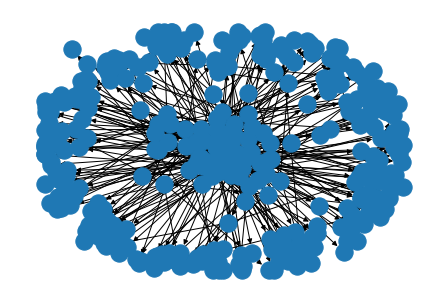

In [656]:
g__ = nx.Graph()
g__.add_edges_from(gateEdges)
print(len(gateEdges))
allDiffusionTime = []
mcaps=[tot_g[i] for i in random.sample(range(0, 500), 20)]
toTakeArgmax=[]
for node in gateNodesList:
#     print(node)
    bfs_tree = nx.bfs_tree(g__, source = node)
    nx.draw(bfs_tree)
    vecOfArgmax=[]
    for mcap in mcaps:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 0.07)
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)

        #Mapping diffusion_time_to_each_node
        
        time_of_diffusion={}
        for i in range(1,node+1):
            time_of_diffusion[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion[j]=i['iteration']
        allDiffusionTime.append(time_of_diffusion)
        
        for node in gateNodesList:
            if node not in time_of_diffusion.keys(): 
                time_of_diffusion[node]=-1
        
#         print("WWWW ",time_of_diffusion[17])
        
#         print("--->> ",sensor_nodes)
#         print("***** ")
#         for s in sensor_nodes:
#             print(time_of_diffusion[s])
#         print("***** ")
        
        min_v=min([time_of_diffusion[i] for i in sensor_nodes])
        min_n=-1
        for i in sensor_nodes:
            if(time_of_diffusion[i]==min_v):
                min_n=i
                break
        mu=[abs(time_of_diffusion[i]+min_v)/2 for i in sensor_nodes if(i!=min_n)]
#         print(len(delta_t),len(mu))
        
        arrivals=[]
        
        for sensor in sensor_nodes:
            if(time_of_diffusion[sensor]==-1):
                arrivals.append(200)
            else:
                arrivals.append(time_of_diffusion[sensor])
                
#         print("arrivals",arrivals)
                
        new_delta_ts = []
            
        for i in range(0,len(arrivals)):
            new_delta_t=[]
            for j in range(0,len(arrivals)):
                if(i!=j):
                    new_delta_t.append(abs(arrivals[j]-arrivals[i]))
            new_delta_ts.append(new_delta_t)
#             print("new_delta_ts",new_delta_ts)
#         print(new_delta_ts)
            
        lambd = []
        for i in range(0,len(new_delta_ts)-1):
#             print("---> ",len(new_delta_ts[i]),len(new_delta_ts[i+1]))
            val = np.correlate(new_delta_ts[i],new_delta_ts[i+1],"same")
            for i in range(0,len(val)):
                if (val[i]==0):
                    val[i]=1
            lambd.append(val)
#         print("lambd",lambd)
#         print("delta_t",delta_t,"mu",mu)    
        sub = np.subtract(delta_t,mu)
#         print("sub",sub)
        lambd[0][1]=0
        powerOfe = np.dot(np.dot((sub), np.linalg.inv(lambd) ),np.transpose(sub))
#         print("powerOfe",powerOfe)
        powerOfe=abs(powerOfe)
        fun = (1/np.linalg.det(lambd))*np.exp(-(1/2)*powerOfe)
        vecOfArgmax.append(fun)
    toTakeArgmax.append(vecOfArgmax)
print(toTakeArgmax)
#     print(node)
# nx.draw(nx.bfs_tree(g, source = 5))
#     print(time_of_diffusion)

In [657]:
print(allDiffusionTime)

[{1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 20: 0, 6: -1, 7: -1, 9: -1, 11: -1, 28: -1, 29: -1, 30: -1, 24: -1, 31: -1, 32: -1, 33: -1, 34: -1, 10: -1, 14: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 29: 0, 28: -1, 30: -1, 24: -1, 31: -1, 32: -1, 33: -1, 34: -1}, {1: 24, 2: 103, 3: 43, 4: -1, 5: 0, 6: 41, 7: 56, 8: -1, 9: 82, 10: 86, 11: 45, 12: -1, 13: -1, 14: 61, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: 29, 28: 51, 33: 86, 24: 101, 31: 108, 30: 135, 34: 154, 29: -1, 32: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 29: 0, 28: -1, 30: -1, 24: -1, 31: -1, 32: -1, 33: -1, 34: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: 0, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 28: -1, 29: -1, 30: -1, 24: -1, 31: -1, 32

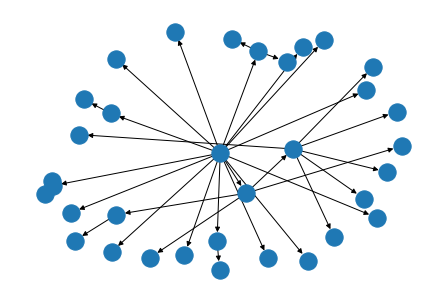

In [658]:
nx.draw(nx.bfs_tree(g, source = 1))

In [659]:
print(len(toTakeArgmax[0]),len(toTakeArgmax))

20 19


In [660]:
finArg = np.argmax(toTakeArgmax,axis=1)

In [661]:
id=-1
mx=-1
for i in range(0,len(finArg)):
    if(toTakeArgmax[i][finArg[i]]>mx):
        mx=toTakeArgmax[i][finArg[i]]
        id=i
clusterNode=gateNodesList[id]

In [662]:
print(clusterNode)

29


In [663]:
partition[clusterNode]
color=partition[clusterNode]
print(partition[clusterNode])

3


In [680]:
print(partition[32])

3


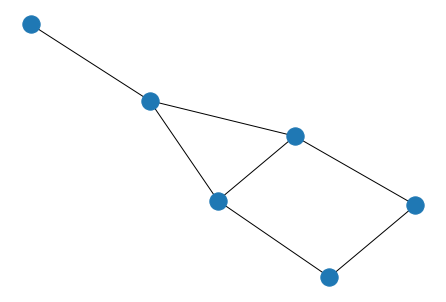

In [665]:
candidateCluster=[]
for e in G.edges():
    if(partition[e[0]]==color and partition[e[1]]==color):
        candidateCluster.append(e)
candidateGraph = nx.Graph()
candidateGraph.add_edges_from(candidateCluster)
nx.draw(candidateGraph)

In [666]:
myset=set([])
for e in candidateCluster:
    myset.add(e[0])
    myset.add(e[1])
print(myset)
my=[]
for ele in myset:
    my.append(ele)
print("list",my)


{32, 24, 25, 26, 28, 29}
list [32, 24, 25, 26, 28, 29]


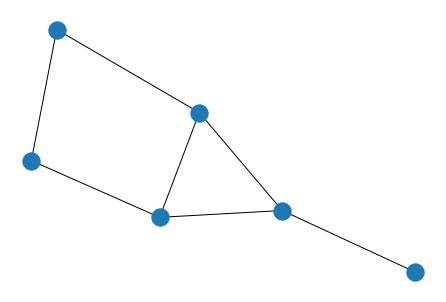

In [667]:
cG = G.subgraph(my)
nx.draw(cG)

500


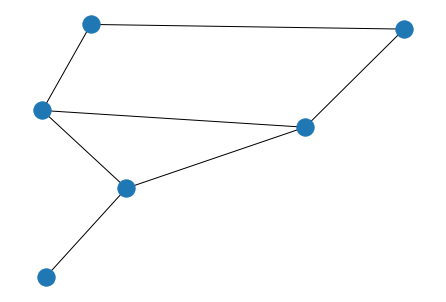

In [668]:
tot_cg_set=set([])
for i in range(0,500):
    tot_cg_set.add(tot_graphs[i].subgraph(my))
print(len(tot_cg_set))
tot_cg=[]
for g in tot_cg_set:
    tot_cg.append(g)
# print(len(tot_cg))
nx.draw(tot_graphs[7].subgraph(my))

In [669]:
print(len(cG.edges()))
nodes_in_cg=[]
nodes_in_cg_set=set([])
for ee in cG.edges():
    nodes_in_cg_set.add(ee[0])
    nodes_in_cg_set.add(ee[1])
for ele in nodes_in_cg_set:
    nodes_in_cg.append(ele)
print("nodes_in_cg",nodes_in_cg)
print(len(tot_cg[0]))
BCS_value_cg=BCS(tot_cg,len(tot_cg)+2,nodes_in_cg)
BCS_value_cg=(sorted(BCS_value_cg.items(), key=lambda x: x[1],reverse=True))

7
nodes_in_cg [32, 24, 25, 26, 28, 29]
6


In [670]:
# Model selection - diffusion time
model = ep.SIModel(cG)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in cG.edges()]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion_cg={}
for i in range(1,node+1):
    time_of_diffusion_cg[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion_cg[j]=i['iteration']

100%|██████████| 200/200 [00:00<00:00, 7693.08it/s]


In [671]:
print(time_of_diffusion_cg)

{1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 26: 0, 24: 4, 25: 4, 32: 10, 28: 39, 29: 61}


In [672]:
sensor_nodes_cg=[BCS_value_cg[i][0] for i in range(0,3)]
print(sensor_nodes_cg)

[32, 26, 25]


In [673]:
delta_t_cg=[]
min_v_cg=min([time_of_diffusion_cg[i] for i in sensor_nodes_cg])
min_n_cg=-1
for i in sensor_nodes_cg:
    if(time_of_diffusion_cg[i]==min_v_cg):
        min_n_cg=i
        break
delta_t_cg=[abs(time_of_diffusion_cg[i]-min_v_cg) for i in sensor_nodes_cg if(i!=min_n_cg)]
print(delta_t_cg)

[10, 4]


100%|██████████| 200/200 [00:00<00:00, 8333.69it/s]


[[2.98823085484675e-08, 1.4386130437612344e-102, 1.4386130437612344e-102, 3.456186098218193e-92, 1.4386130437612344e-102, 3.456186098218193e-92, 6.212787007514508e-10, 6.212787007514508e-10, 1.4386130437612344e-102, 1.4386130437612344e-102, 5.311253023730689e-08, 6.212787007514508e-10, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.4386130437612344e-102, 3.456186098218193e-92, 3.456186098218193e-92, 1.4386130437612344e-102, 1.4386130437612344e-102, 2.0977262899877807e-05], [5.332357235017821e-07, 6.092424779159516e-08, 2.2030484277784938e-07, 1.1230796839012457e-07, 3.613234672977583e-05, 3.456186098218193e-92, 1.4386130437612344e-102, 8.778732991397402e-07, 1.4386130437612344e-102, 1.4386130437612344e-102, 1.3851597062071146e-96, 1.4386130437612344e-102, 6.832814118157024e-07, 3.456186098218193e-92, 1.4386130437612344e-102, 1.3851597062071146e-96, 1.4386130437612344e-102, 1.4386130437612344e-102, 3.456186098218193e-92, 1.7358768065016827e-78], [1.4386130437612344e-102, 1.38515970

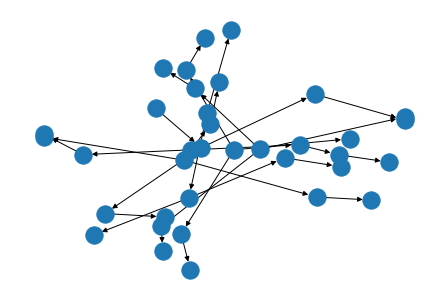

In [674]:
g___cg = nx.Graph()
g___cg.add_edges_from(cG.edges())
# allDiffusionTime = []
mcaps_cg=[tot_cg[i] for i in random.sample(range(0, 500), 20)]
toTakeArgmax_cg=[]
for node in nodes_in_cg:
#     print(node)
    bfs_tree = nx.bfs_tree(g___cg, source = node)
    nx.draw(bfs_tree)
    vecOfArgmax_cg=[]
    for mcap_cg in mcaps_cg:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in bfs_tree.edges()]))
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)

        #Mapping diffusion_time_to_each_node
        
        time_of_diffusion_cg={}
        for i in range(1,node+1):
            time_of_diffusion_cg[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion_cg[j]=i['iteration']
        
        for node in nodes_in_cg:
            if node not in time_of_diffusion_cg.keys(): 
                time_of_diffusion_cg[node]=-1
        
        min_v_cg=min([time_of_diffusion_cg[i] for i in sensor_nodes_cg])
        min_n_cg=-1
        for i in sensor_nodes_cg:
            if(time_of_diffusion_cg[i]==min_v_cg):
                min_n_cg=i
                break
        mu_cg=[abs(time_of_diffusion_cg[i]+min_v_cg)/2 for i in sensor_nodes_cg if(i!=min_n_cg)]
#         print(len(delta_t_cg),len(mu_cg))
        
        arrivals_cg=[]
        
        for sensor in sensor_nodes_cg:
            if(time_of_diffusion_cg[sensor]==-1):
                arrivals_cg.append(200)
            else:
                arrivals_cg.append(time_of_diffusion_cg[sensor])
                
#         print("arrivals_cg",arrivals_cg)
                
        new_delta_ts_cg = []
            
        for i in range(0,len(arrivals_cg)):
            new_delta_t_cg=[]
            for j in range(0,len(arrivals_cg)):
                if(i!=j):
                    new_delta_t_cg.append(abs(arrivals_cg[j]-arrivals_cg[i]))
            new_delta_ts_cg.append(new_delta_t_cg)
#             print("new_delta_ts_cg",new_delta_ts_cg)
#         print(new_delta_ts_cg)
            
        lambd_cg = []
        for i in range(0,len(new_delta_ts_cg)-1):
#             print("---> ",len(new_delta_ts_cg[i]),len(new_delta_ts_cg[i+1]))
            val_cg = np.correlate(new_delta_ts_cg[i],new_delta_ts_cg[i+1],"same")
            for i in range(0,len(val_cg)):
                if (val_cg[i]==0):
                    val_cg[i]=1
            lambd_cg.append(val_cg)
#         print("lambd_cg",lambd_cg)
#         print("delta_t_cg",delta_t_cg,"mu_cg",mu_cg)    
        sub_cg = np.subtract(delta_t,mu_cg)
#         print("sub_cg",sub_cg)
        lambd_cg[0][1]=0
        powerOfe_cg = np.dot(np.dot((sub_cg), np.linalg.inv(lambd_cg) ),np.transpose(sub_cg))
#         print("powerOfe_cg",powerOfe_cg)
        powerOfe_cg=abs(powerOfe_cg)
        fun_cg = (1/np.linalg.det(lambd_cg))*np.exp(-(1/2)*powerOfe_cg)
        vecOfArgmax_cg.append(fun_cg)
    toTakeArgmax_cg.append(vecOfArgmax_cg)
print(toTakeArgmax_cg)
#     print(node)
# nx.draw(nx.bfs_tree(g, source = 5))
#     print(time_of_diffusion)

In [675]:
print(len(toTakeArgmax_cg[0]),len(toTakeArgmax_cg))

20 6


In [676]:
finArg_cg = np.argmax(toTakeArgmax_cg,axis=1)

In [677]:
id_cg=-1
mx_cg=-1
for i in range(0,len(finArg_cg)):
    if(toTakeArgmax_cg[i][finArg_cg[i]]>mx):
        mx_cg=toTakeArgmax_cg[i][finArg_cg[i]]
        id_cg=i
source_node=nodes_in_cg[id_cg]
print(source_node)

29


In [679]:
print(partition[source_node])
print(partition[32])

3
3
